<a href="https://colab.research.google.com/github/mfilipak/AFRAC_IA/blob/main/005B_Experimentos_usando_CNN_para_representar_descri%C3%A7%C3%A3o.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Experimento 005B
##Objetivo: Experimentos e reprodução de trabalhos com word embeddings usando como corpo o campo de descrição (até 120 caracteres com ou sem padding). Com foco em CNN 1D e redes siamesas. Espera-se que tenha um bom potencial de agrupar palavras por GTIN, NCM entre outros.
##Fonte dos dados: dataset público do portal da transparência - Campos de descrição e NCM.


#Referências:
* https://arxiv.org/pdf/1509.01626.pdf - Character-level Convolutional Networks for Text Classification - Esse paper é um bom ponto de partida. Tem a coparticipação do Yann LeCun, criador das CNNs.
* https://github.com/ahmedbesbes/character-based-cnn - Implementação do paper acima.
* https://www.youtube.com/watch?v=CNY8VjJt-iQ - Vídeo explicando a implementação do Ahmed para o paper.
* https://aclanthology.org/W16-1617.pdf - Não pretendo usar essa nesse experimento mas é um bom ponto de partida caso se queira usar RNN em uma rede siamesa.
* http://aclanthology.lst.uni-saarland.de/P16-1036.pdf - Abordagem semelhante usando redes siamesas para encontrar perguntas semelhantes no QUORA.
* https://www.kaggle.com/c/quora-question-pairs/discussion/33631
* https://explosion.ai/blog/quora-deep-text-pair-classification - Bom artigo embora não seja orientado a CNNs.
* https://github.com/BrambleXu/nlp-beginner-guide-keras/blob/master/char-level-cnn/char_cnn.py - Outra implementação, essa em Keras.
* https://arxiv.org/pdf/1408.5882.pdf - Classificação de sentenças, comparando CNN com outras técnicas. Um pouco outdated (2015)
*<b> https://towardsdatascience.com/character-level-cnn-with-keras-50391c3adf33 - Mais uma implementação em Keras - ponto de partida para esse notebook</b>
* https://repositorio.pucrs.br/dspace/bitstream/10923/15243/2/Measuring_Semantic_Similarity_Between_Sentences_Using_a_Siamese_Neural_Network.pdf - Paper de alguns autores Brasileiros da PUC RS usa rede siamesa com arquitetura GRU.


#Dica: Altere o tipo de runtime para usar GPU, os treinos desse notebook são relativamente pesados para rodar em CPU.<br><br>
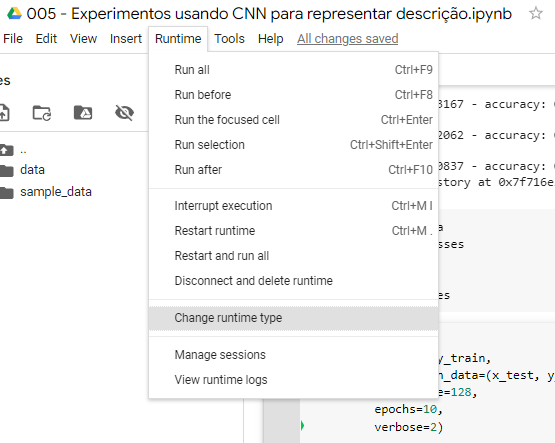

In [ ]:
import requests
import os
import pandas as pd

import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from tensorflow.keras.layers import Input, Embedding, Activation, Flatten, Dense
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split


In [ ]:
#Copia os dados das NFEs do portal da cidadância pro drive virtual.
import requests  
file_url = "https://raw.githubusercontent.com//mfilipak/AFRAC_IA/main/DATASET/202201_NFe_NotaFiscalItem.zip"
r = requests.get(file_url, stream = True) 

with open("portal.zip", "wb") as file:  
    for block in r.iter_content(chunk_size = 1024): 
         if block:  
             file.write(block)

DATA_FILE = "portal.zip"
df = pd.read_csv(DATA_FILE, encoding="CP1252",sep=";")
print("O dataframe completo contém:",len(df),"linhas")

df3 = df[['DATA EMISSÃO','DESCRIÇÃO DO PRODUTO/SERVIÇO', 'CÓDIGO NCM/SH', 'CFOP']]
df3.columns = ["DATA", "DESCR", "NCM", "CFOP"]
df3 = df3[df3["NCM"]!=-1] #Filtrando NCMs = -1

text_lengths = np.array([len(_) for _ in df3['DESCR']])
df3 = df3[text_lengths>=3]

#Caso queira eliminar as repetições rodar a linha abaixo
df3 = df3.drop_duplicates(subset=["DESCR", "NCM", "CFOP"])
print("O dataframe sem repetiçoes contém:",len(df3),"linhas")
df3[:1]

O dataframe completo contém: 324056 linhas
O dataframe sem repetiçoes contém: 155038 linhas


DATA                                DESCR       NCM  CFOP
0  01/01/2022 00:02:22  HP RESERVATORIO DE RESIDUO DE TONER  84439939  6949

In [ ]:
descs = [_.lower() for _ in df3["DESCR"]]
tk = Tokenizer(num_words=None, char_level=True, oov_token='UNK')
tk.fit_on_texts(descs)
print(tk.word_index)
print(f"{len(tk.word_index)} caracteres.")
print("".join(sorted([_ for _ in tk.word_index])))
descs = [_+(120-len(_))*" " for _ in descs]
df3["DESCR_NORM"] = descs
df3[-5:]

{'UNK': 1, ' ': 2, 'a': 3, 'o': 4, 'e': 5, 'r': 6, 'i': 7, 't': 8, 'c': 9, 'l': 10, 'm': 11, 's': 12, 'n': 13, '0': 14, 'd': 15, 'p': 16, 'u': 17, '1': 18, '2': 19, 'g': 20, 'b': 21, 'f': 22, 'v': 23, '-': 24, '5': 25, '3': 26, '.': 27, 'x': 28, '4': 29, '/': 30, 'h': 31, ',': 32, '6': 33, '8': 34, '7': 35, '9': 36, ':': 37, 'k': 38, 'z': 39, 'j': 40, 'q': 41, '(': 42, ')': 43, 'w': 44, 'y': 45, '|': 46, 'ç': 47, 'ã': 48, '#': 49, '%': 50, "'": 51, '+': 52, 'á': 53, '*': 54, ';': 55, 'ó': 56, 'í': 57, 'é': 58, '$': 59, '_': 60, 'ê': 61, '=': 62, 'â': 63, 'º': 64, '?': 65, 'ú': 66, ']': 67, '[': 68, '&': 69, '\\': 70, '°': 71, 'ô': 72, '>': 73, 'õ': 74, '²': 75, 'à': 76, 'ø': 77, '!': 78, '~': 79, '<': 80, '`': 81, 'ª': 82, 'µ': 83, '®': 84, '³': 85, '@': 86, '©': 87, '¾': 88, '}': 89, '{': 90, '¡': 91, 'è': 92, '\xad': 93, 'ì': 94, '\x7f': 95, 'ò': 96, 'ü': 97, 'þ': 98, 'ù': 99}
99 caracteres.
 !#$%&'()*+,-./0123456789:;<=>?@UNK[\]_`abcdefghijklmnopqrstuvwxyz{|}~¡©ª­®°²³µº¾àáâãçèéêìíò

DATA                                  DESCR       NCM  \
324044  31/01/2022 23:54:45      FAROL DE MILHA ESQUERDO / DIREITO  85149000   
324045  31/01/2022 23:54:45           FAROL LADO ESQUERDO/ DIREITO  85149000   
324046  31/01/2022 23:54:45  CUBO DE RODA DIANT DIREITO / ESQUERDO  87089529   
324048  31/01/2022 23:55:00          POLTRONA PRESIDENTE GIRATORIA  94021000   
324053  31/01/2022 23:59:59                  Leite Cru Refrigerado   4014010   

        CFOP                                         DESCR_NORM  
324044  5405  farol de milha esquerdo / direito             ...  
324045  5405  farol lado esquerdo/ direito                  ...  
324046  5405  cubo de roda diant direito / esquerdo         ...  
324048  6102  poltrona presidente giratoria                 ...  
324053  1135  leite cru refrigerado                         ...

In [ ]:
df3["DESCR_NORM"].values

array(['hp reservatorio de residuo de toner                                                                                     ',
       'mltd201lxaz cartucho de toner preto 20k paginas                                                                         ',
       'cltc609sxaz cartucho de toner ciano 7k paginas                                                                          ',
       ...,
       'cubo de roda diant direito / esquerdo                                                                                   ',
       'poltrona presidente giratoria                                                                                           ',
       'leite cru refrigerado                                                                                                   '],
      dtype=object)

https://classificadorfiscal.com.br/uploads/1/0/6/1/106125045/secaoecap.html

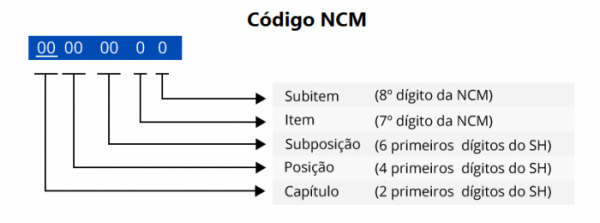

In [ ]:
capitulos = [ int(f"{_:08}"[:2]) for _ in df3["NCM"] ]
df3["CAPITULO"] = capitulos
print(f"Capítulos encontrados no NCM: {len(df3['CAPITULO'].unique())}")

Capítulos encontrados no NCM: 98


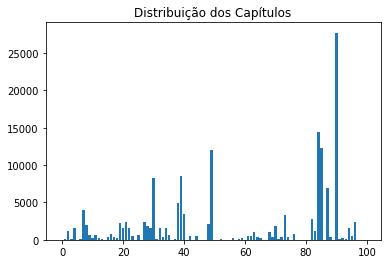

In [ ]:
#df3.count("CAPITULO")
plt.title("Distribuição dos Capítulos")
plt.bar(df3["CAPITULO"].value_counts().index, df3["CAPITULO"].value_counts().values)
plt.show()

In [ ]:
# Convert string to index
X_sequences = tk.texts_to_sequences(descs)
X = np.array(X_sequences, dtype='float32')
X.shape

(155038, 120)

In [ ]:
Y = to_categorical(capitulos)
Y.shape

(155038, 100)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.1, random_state=42)

In [ ]:
X_train.shape, y_train.shape

((139534, 120), (139534, 100))

In [ ]:
vocab_size = len(tk.word_index)
vocab_size

99

In [ ]:
embedding_weights = [] #(71, 70)
embedding_weights.append(np.zeros(vocab_size)) # first row is pad

for char, i in tk.word_index.items(): # from index 1 to 70
    onehot = np.zeros(vocab_size)
    onehot[i-1] = 1
    embedding_weights.append(onehot)
embedding_weights = np.array(embedding_weights)

In [ ]:
print(embedding_weights.shape) # first row all 0 for PAD, 69 char, last row for UNK
embedding_weights

(100, 99)


array([[0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.]])

In [205]:
# parameter 
input_size = 120
embedding_size = 99
#conv_layers = [[256, 7, 3], 
#               [256, 7, 3], 
#               [256, 3, -1], 
#               [256, 3, -1], 
#               [256, 3, -1], 
#               [256, 3, 3]]


conv_layers = [[256, 7, 3], 
               [64, 7, 3], 
               [64, 3, -1], 
               [64, 3, -1], 
               [64, 3, -1]]


#fully_connected_layers = [1024, 1024]
fully_connected_layers = [256, 128]
num_of_classes = 100
dropout_p = 0.5
optimizer = 'adam'
loss = 'categorical_crossentropy'

In [ ]:
# Embedding layer Initialization
embedding_layer = Embedding(vocab_size+1, 
                            embedding_size,
                            input_length=input_size,
                            weights=[embedding_weights])

In [206]:
# Model 

# Input
inputs = Input(shape=(input_size,), name='input', dtype='int64')  # shape=(?, 1014)
# Embedding 
x = embedding_layer(inputs)
# Conv 
for filter_num, filter_size, pooling_size in conv_layers:
    x = Conv1D(filter_num, filter_size)(x) 
    x = Activation('relu')(x)
    if pooling_size != -1:
        x = MaxPooling1D(pool_size=pooling_size)(x) # Final shape=(None, 34, 256)
x = Flatten()(x) # (None, 8704)
# Fully connected layers 
for dense_size in fully_connected_layers:
    x = Dense(dense_size, activation='relu')(x) # dense_size == 1024
    x = Dropout(dropout_p)(x)
# Output Layer
predictions = Dense(num_of_classes, activation='softmax')(x)
# Build model
model = Model(inputs=inputs, outputs=predictions)
model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy']) # Adam, categorical_crossentropy
model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 120)]             0         
                                                                 
 embedding_4 (Embedding)     (None, 120, 99)           9900      
                                                                 
 conv1d_28 (Conv1D)          (None, 114, 256)          177664    
                                                                 
 activation_28 (Activation)  (None, 114, 256)          0         
                                                                 
 max_pooling1d_13 (MaxPoolin  (None, 38, 256)          0         
 g1D)                                                            
                                                                 
 conv1d_29 (Conv1D)          (None, 32, 64)            114752    
                                                           

In [207]:
x_train = X_train[:]
x_test = X_test[:]


In [282]:
# Training
model.fit(x_train, y_train[:len(x_train)],
          validation_data=(x_test, y_test[:len(x_test)]),
          batch_size=128,
          epochs=100,
          verbose=2)

Epoch 1/100
1091/1091 - 11s - loss: 0.5789 - accuracy: 0.8582 - val_loss: 1.6851 - val_accuracy: 0.7147 - 11s/epoch - 10ms/step
Epoch 2/100
1091/1091 - 11s - loss: 0.5742 - accuracy: 0.8600 - val_loss: 1.6893 - val_accuracy: 0.7145 - 11s/epoch - 10ms/step
Epoch 3/100
1091/1091 - 11s - loss: 0.5806 - accuracy: 0.8582 - val_loss: 1.7032 - val_accuracy: 0.7137 - 11s/epoch - 10ms/step
Epoch 4/100
1091/1091 - 11s - loss: 0.5798 - accuracy: 0.8585 - val_loss: 1.7195 - val_accuracy: 0.7175 - 11s/epoch - 10ms/step
Epoch 5/100
1091/1091 - 11s - loss: 0.5688 - accuracy: 0.8606 - val_loss: 1.7423 - val_accuracy: 0.7157 - 11s/epoch - 10ms/step
Epoch 6/100
1091/1091 - 11s - loss: 0.5737 - accuracy: 0.8606 - val_loss: 1.6943 - val_accuracy: 0.7127 - 11s/epoch - 10ms/step
Epoch 7/100
1091/1091 - 11s - loss: 0.5684 - accuracy: 0.8611 - val_loss: 1.6884 - val_accuracy: 0.7116 - 11s/epoch - 10ms/step
Epoch 8/100
1091/1091 - 11s - loss: 0.5703 - accuracy: 0.8609 - val_loss: 1.7383 - val_accuracy: 0.7131 

In [283]:
model.save("CNN1D_DESC_NCM.H5", save_format="h5")

In [284]:
pred = model.predict(X)

In [285]:
df3["CAP_PRED"] = [ np.argmax(_) for _ in pred[:]]

In [286]:
1 - len(df3[df3["CAPITULO"] != df3["CAP_PRED"]])/len(df3)

0.8825578245333402

In [287]:
df3[df3["CAPITULO"] != df3["CAP_PRED"]][:20]

DATA                                              DESCR  \
58   01/01/2022 10:45:00                                   NIPLE EMENDA 1/4   
59   01/01/2022 10:45:00                               PLACA LED ILUMINACAO   
63   01/01/2022 10:55:00                                       LACRE REPARO   
64   01/01/2022 10:55:00                                GUIA DA GAVETA MTCO   
65   01/01/2022 10:55:00                AGULHA DE VELOCIDADE 1D/125 KM MTCO   
74   01/01/2022 11:59:00                                   PAO DOCE DE COCO   
75   01/01/2022 11:59:00                                     PAO MASSA FINA   
79   01/01/2022 13:09:15                                   CREME DENTAL 90G   
131  01/01/2022 15:58:08                Lona Polietileno 5m X 5m 100 Micras   
156  02/01/2022 00:00:00                      AMOSTRAS DE AGUA PARA ANALISE   
509  02/01/2022 15:00:00                ACIONADOR MANUAL CONTROLE DE ACESSO   
514  02/01/2022 15:23:00  ESTANTE DE ARAME REVESTIDO PVC PARA 12 TUBOS D...   
560  02/01/2022 18:57:02                                  DESODORANTE SPRAY   
561  02/01/2022 18:57:02                                  DEO COLONIA 100ML   
562  02/01/2022 18:57:02                LENCO UMEDECIDO PCT COM 70 UNIDADES   
575  02/01/2022 22:01:00    MAGNÉSIO EM FITAS 25 GR. LOTE 7697 VAL. 08/2025   
580  02/01/2022 22:29:00  MAGNÉSIO EM FITAS CAS 7439-95-4  25 GR. LOTE 7...   
602  02/01/2022 23:52:00                      COENTRO, ESPECIE COMUM - MACO   
612  03/01/2022 00:00:00                                    PLACA VIDEO 2GB   
617  03/01/2022 00:00:00                                  MOLHO SHOYO 150ML   

          NCM  CFOP                                         DESCR_NORM  \
58   39174090  5102  niple emenda 1/4                              ...   
59   94051099  5102  placa led iluminacao                          ...   
63   90299010  5102  lacre reparo                                  ...   
64   90299010  5102  guia da gaveta mtco                           ...   
65   90299010  5102  agulha de velocidade 1d/125 km mtco           ...   
74   21069090  5405  pao doce de coco                              ...   
75   21069090  5405  pao massa fina                                ...   
79   33061000  6102  creme dental 90g                              ...   
131  63061200  6108  lona polietileno 5m x 5m 100 micras           ...   
156  22021000  6949  amostras de agua para analise                 ...   
509  83016000  6403  acionador manual controle de acesso           ...   
514  82032090  6108  estante de arame revestido pvc para 12 tubos d...   
560  33072010  6102  desodorante spray                             ...   
561  33030020  6102  deo colonia 100ml                             ...   
562  48182000  6102  lenco umedecido pct com 70 unidades           ...   
575  81042000  6102  magnésio em fitas 25 gr. lote 7697 val. 08/202...   
580  81042000  6102  magnésio em fitas cas 7439-95-4  25 gr. lote 7...   
602   7099990  5102  coentro, especie comum - maco                 ...   
612  84733043  6403  placa video 2gb                               ...   
617  24039910  5102  molho shoyo 150ml                             ...   

     CAPITULO  CAP_PRED  
58         39        84  
59         94        90  
63         90        87  
64         90        84  
65         90        49  
74         21        19  
75         21        19  
79         33        38  
131        63        39  
156        22        21  
509        83        85  
514        82        39  
560        33        35  
561        33        21  
562        48        56  
575        81        49  
580        81        75  
602         7         8  
612        84        85  
617        24        21